# MULTILEVEL REGRESSION AND POSTSTRATIFICATION 

We will explore the opinion on the question: "Should employers be allowed to decline coverage of abortions in insurance plans? (YES / NO)" in the US society. The survey was answered by approximately 60 000 US citizens and the result was 43/57 for YES/NO. We will look at:
-  how our model predicts the opinion of the whole US population (data for over 200 000 000 citizens)
-  how would the model behave if the survey was much smaller (5000 participants) or imbalanced and mostly answered by a specific group of the society (old white males)
-  what if we had another feature in the survey (partisanship) but we don't have this type of data for the whole population

In [30]:
#!pip install pyro-ppl==1.5.2
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import linear_model
import seaborn as sns
import torch
import math
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
import warnings
warnings.filterwarnings('ignore')

# fix random generator seed (for reproducibility of results)
np.random.seed(42)
torch.random.manual_seed(42)
pyro.set_rng_seed(42)
# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

In [31]:
# Progress Bar
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)


# 1) DATA LOADING

Data about the US states: a categorical feature "region" and a numerical feature "republican support"

In [32]:
df = pd.read_csv("Data/cces_all_clean.csv")
states = pd.read_excel("Data/states.xlsx")
states = states.rename(columns={'republican support percentage':"rep_sup"})

In [33]:
states.head()

,states,rep_sup,region
0,AK,0.51,west
1,AL,0.62,southeast
2,AR,0.60,southeast
3,AZ,0.48,southwest
4,CA,0.31,west


Survey data with the categorical features: "state", "ethinicity", "gender", "age", "education".

In [34]:
categories = ["state", "eth", "male", "age", "educ"]
for category in categories:
    df[category+"_cat"] = df[category].astype('category').cat.codes
states["region"] = states["region"].astype('category').cat.codes
df.head()

,abortion,state,eth,male,age,educ,state_cat,eth_cat,male_cat,age_cat,educ_cat
0,1,MD,Other,-0.5,50-59,Some college,19,2,0,3,4
1,1,TN,White,-0.5,40-49,HS,41,3,0,2,1
2,1,OH,White,-0.5,60-69,Some college,34,3,0,4,4
3,0,CA,Other,-0.5,70+,Post-grad,4,2,0,5,3
4,1,KY,White,-0.5,40-49,HS,16,3,0,2,1


# 2) MODEL FITTING

In [35]:
states_x = states.iloc[:,1:].values
states_x = torch.tensor(states_x).float()

In [36]:
mat = df.iloc[:,6:].values
X = mat
X = torch.tensor(X).float()
y = df.iloc[:,0].values
y = torch.tensor(y).float()
print(X.shape)
print(states_x.shape)
print(y)

torch.Size([59810, 5])
torch.Size([50, 2])
tensor([1., 1., 1.,  ..., 0., 0., 0.])


## BASELINES

a) Always predicting "NO"

In [37]:
y_true = y.numpy()
np.sum(np.zeros(len(y_true)) == y_true)/len(y_true)

0.5658418324694867

b) Logistic Regression

In [38]:
from sklearn.linear_model import LogisticRegression
df_2 = pd.read_csv("Data/cces_all_clean.csv")
states = pd.read_excel("Data/states.xlsx")
states = states.rename(columns={'republican support percentage':"rep_sup"})
df_2 = df_2.merge(states,left_on = "state", right_on = "states")
df_2 = df_2.drop("states", axis = 1)
category_columns = ["state", "eth", "male", "age", "educ", "region"]
for col in category_columns:
    df_2[col] = df_2[col].astype('category')
df_regr = pd.get_dummies(df_2, columns=category_columns, drop_first=True)
    
train_perc = 1 #0.66 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y))
ix_train = perm[:split_point]
#ix_test = perm[split_point:]
X_train = df_regr.iloc[:,1:].values[ix_train,:]
#X_test = df_regr.iloc[:,1:].values[ix_test,:]
y_train = df_regr.iloc[:,0].values[ix_train]
#y_test = df_regr.iloc[:,0].values[ix_test]
print("num train: %d" % len(y_train))
#print("num test: %d" % len(y_test))

regr = LogisticRegression()
regr.fit(X_train, y_train)
y_hat = regr.predict(X_train)


print("predictions:", y_hat)
print("true values:", y_train)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_train) / len(y_train))

num train: 59810
predictions: [0 0 0 ... 0 0 0]
true values: [0 1 0 ... 1 1 0]
Accuracy: 0.6015549239257649


## VARIATIONAL INFERENCE

In [39]:
def model(X, states_x, obs=None):
    
    sigmas = pyro.sample("sigmas", dist.HalfCauchy(torch.ones(8)*5.))
    gammas = pyro.sample("gammas", dist.Normal(torch.zeros(7), 5.0))
    alpha_educ = pyro.sample("alpha_educ", dist.Normal(torch.zeros(5), sigmas[0]))
    alpha_eth = pyro.sample("alpha_eth", dist.Normal(torch.zeros(4), sigmas[1]))
    alpha_age = pyro.sample("alpha_age", dist.Normal(torch.zeros(6), sigmas[2]))
    alpha_male_eth = pyro.sample("alpha_male_eth", dist.Normal(torch.zeros((2,4)), sigmas[3]))
    alpha_educ_age = pyro.sample("alpha_educ_age", dist.Normal(torch.zeros((5,6)), sigmas[4]))
    alpha_educ_eth = pyro.sample("alpha_educ_eth", dist.Normal(torch.zeros((5,4)), sigmas[5]))
    
    ####################
    #alpha_state = pyro.sample("alpha_state", dist.Normal(torch.zeros(50), sigmas[6]))
    ####################
    
    beta_male = pyro.sample("beta_male", dist.Normal(0.,5.))
    with pyro.plate("data", size=len(X), subsample_size=1000) as ind:
        state = X[ind,0].tolist()
        eth = X[ind,1].tolist()
        male = X[ind,2].tolist()
        male_t = X[ind,2]
        age = X[ind,3].tolist()
        educ = X[ind,4].tolist()
        y = pyro.sample("y",dist.Bernoulli(torch.sigmoid(gammas[5] + gammas[6]* states_x[:,0][state] + gammas[states_x[:,1][state].tolist()]+ alpha_educ[educ] + alpha_eth[eth] + alpha_age[age] + alpha_male_eth[male, eth] + alpha_educ_age[educ,age] + alpha_educ_eth[educ, eth] + beta_male*male_t)), obs= obs[ind])
    return y

In [40]:
def train_SVI(X,y,states_x,model):
    # Define guide function
    guide = AutoDiagonalNormal(model)

    # Reset parameter values
    pyro.clear_param_store()

    # Define the number of optimization steps
    n_steps = 6000

    # Setup the optimizer
    adam_params = {"lr": 0.01}
    optimizer = ClippedAdam(adam_params)

    # Setup the inference algorithm
    elbo = Trace_ELBO(num_particles=3)
    svi = SVI(model, guide, optimizer, loss=elbo)

    # Do gradient steps
    for step in range(n_steps):
        elbo = svi.step(X,states_x,y)
        if step % 500 == 0:
            print("[%d] ELBO: %.1f" % (step, elbo))
    return guide

In [41]:
#guide = train_SVI(X,y,states_x,model)

In [42]:
#torch.save({"guide" : guide}, "mymodel.pt")
#pyro.get_param_store().save("mymodelparams.pt")

In [43]:
from pyro.infer import Predictive
def sample_params(guide,X,states_x, y, model, num = 2000):
    predictive = Predictive(model, guide=guide, num_samples=num,
                            return_sites=("alpha_educ", "alpha_eth", "alpha_age", "beta_male", "alpha_educ_age", "alpha_educ_eth", "alpha_male_eth", "gammas", "y"))
    samples = predictive(X,states_x, y)
    params =["alpha_educ", "alpha_eth", "alpha_age", "gammas", "beta_male", "alpha_educ_age", "alpha_educ_eth", "alpha_male_eth"]
    params_samples = {}
    for param in params:
        params_samples[param] = samples[param].detach().numpy()
    return samples, params_samples

In [44]:
saved_model_dict = torch.load("mymodel.pt")
guide = saved_model_dict['guide']
pyro.get_param_store().load("mymodelparams.pt")
samples, params_samples = sample_params(guide, X,states_x, y,model)

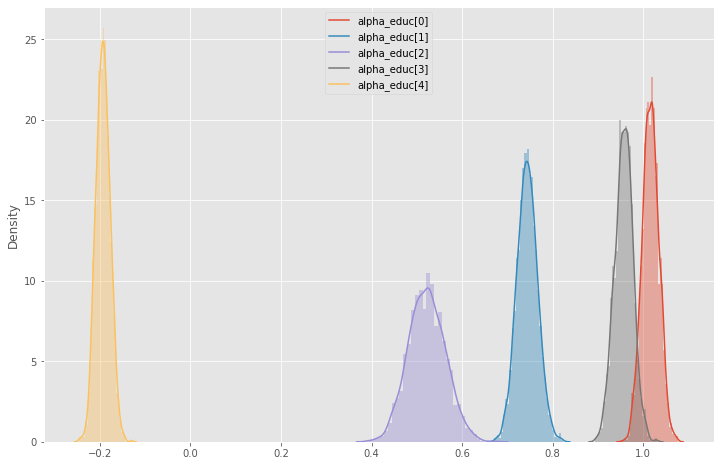

In [45]:
n_cat = 5
for c in range(n_cat):
    sns.distplot(params_samples["alpha_educ"][:,c])
plt.legend(["alpha_educ[%d]" % c for c in range(n_cat)])
plt.show()

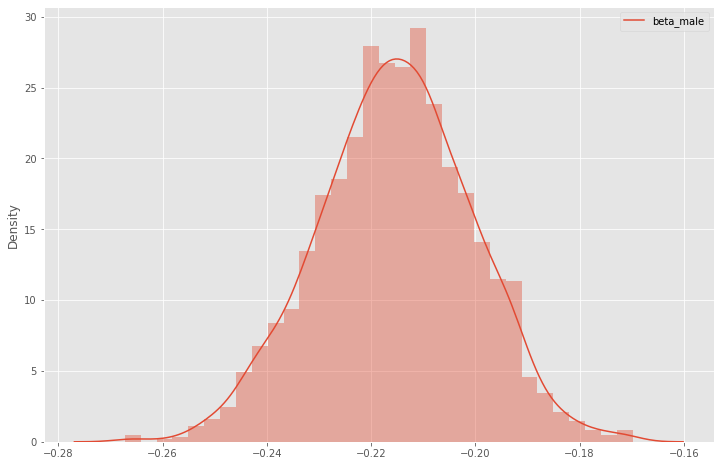

In [46]:
sns.distplot(params_samples["beta_male"])
plt.legend(["beta_male"])
plt.show()

In [47]:
# make predictions for the train set
def sigmoid_n(x):
    x = x.numpy()
    return 1 / (1 + np.exp(-x))
def compute_accuracy(samples,X,y,states_x):
    params_hat = {}
    params =["alpha_educ", "alpha_eth", "alpha_age", "gammas", "beta_male", "alpha_educ_age", "alpha_educ_eth", "alpha_male_eth"]
    # extract expected values of the parameters
    for param in params:
        params_hat[param] = samples[param].mean(axis=0).detach().numpy()
    state = X[:,0].int().tolist()
    eth = X[:,1].int().tolist()
    male = X[:,2].int().tolist()
    male_t = X[:,2].numpy()
    age = X[:,3].int().tolist()
    educ = X[:,4].int().tolist()
    y_hat = np.round(sigmoid_n(params_hat["gammas"][5]+ params_hat["gammas"][6]* states_x[:,0][state]+ params_hat["gammas"][states_x[:,1][state].int().tolist()] +params_hat["alpha_educ"][educ]+ params_hat["alpha_eth"][eth] + params_hat["alpha_age"][age] + params_hat["alpha_male_eth"][male, eth] + params_hat["alpha_educ_age"][educ, age] + params_hat["alpha_educ_eth"][educ, eth] +params_hat["beta_male"]*male_t))
    y_true = y.numpy()
    print("predictions:", y_hat)
    print("true values:", y_true)

    # evaluate prediction accuracy
    print("Accuracy:", 1.0*np.sum(y_hat == y_true) / len(y_true))
compute_accuracy(samples,X,y,states_x)

predictions: [0. 1. 0. ... 0. 0. 0.]
true values: [1. 1. 1. ... 0. 0. 0.]
Accuracy: 0.5971075071058352


## MARKOV CHAIN MONTE CARLO

In [48]:
import numpyro
import numpyro.distributions as ndist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, HMC

def model2(X, obs=None):
    
    sigmas = numpyro.sample("sigmas", ndist.HalfCauchy(5.), sample_shape = (8,))
    gammas = numpyro.sample("gammas", ndist.Normal(0., 5.), sample_shape = (7,))
    alpha_educ = numpyro.sample("alpha_educ", ndist.Normal(0., sigmas[0]), sample_shape = (5,))
    alpha_eth = numpyro.sample("alpha_eth", ndist.Normal(0., sigmas[1]), sample_shape = (4,))
    alpha_age = numpyro.sample("alpha_age", ndist.Normal(0., sigmas[2]), sample_shape = (6,))
    alpha_male_eth = numpyro.sample("alpha_male_eth", ndist.Normal(0., sigmas[3]), sample_shape = (2,4))
    alpha_educ_age = numpyro.sample("alpha_educ_age", ndist.Normal(0., sigmas[4]), sample_shape = (5,6))
    alpha_educ_eth = numpyro.sample("alpha_educ_eth", ndist.Normal(0., sigmas[5]), sample_shape = (5,4))
    
    beta_male = numpyro.sample("beta_male", ndist.Normal(0.,5.))
    with numpyro.plate("data", size = len(X)):
        state = X[:,0].tolist()
        eth = X[:,1].tolist()
        male = X[:,2].tolist()
        male_t = X[:,2]
        age = X[:,3].tolist()
        educ = X[:,4].tolist()
        y = numpyro.sample("y", ndist.Bernoulli(jax.nn.sigmoid(gammas[5] + gammas[6]* jnp.array(states_x[:,0][state]) + gammas[jnp.array(states_x[:,1][state],dtype = int)]+ alpha_educ[jnp.array(educ, dtype = int)] + alpha_eth[jnp.array(eth, dtype = int)] + alpha_age[jnp.array(age, dtype = int)] + alpha_male_eth[jnp.array(male, dtype = int), jnp.array(eth, dtype = int)] + alpha_educ_age[jnp.array(educ, dtype = int), jnp.array(age, dtype = int)] + alpha_educ_eth[jnp.array(educ, dtype = int), jnp.array(eth, dtype = int)] + beta_male*jnp.array(male_t))), obs= jnp.array(obs))
    return y

In [49]:
"""
import time
import jax
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
from jax import lax
t0 = time.time()

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model2, max_tree_depth=8, step_size=5e-3, adapt_step_size=False)
mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=500, num_chains=1)
mcmc.run(rng_key_, X, y)

t_fin = time.time()

print("Total time: {0:.3f}m".format((t_fin - t0)/60))

hmc_samples = {k: np.asarray(v) for k, v in mcmc.get_samples().items()}
np.save('mcmc_posterior.npy',  hmc_samples) 
"""

'\nimport time\nimport jax\nimport jax.numpy as jnp\nfrom jax import random, vmap\nfrom jax.scipy.special import logsumexp\nfrom jax import lax\nt0 = time.time()\n\nrng_key = random.PRNGKey(0)\nrng_key, rng_key_ = random.split(rng_key)\n\nnuts_kernel = NUTS(model=model2, max_tree_depth=8, step_size=5e-3, adapt_step_size=False)\nmcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=500, num_chains=1)\nmcmc.run(rng_key_, X, y)\n\nt_fin = time.time()\n\nprint("Total time: {0:.3f}m".format((t_fin - t0)/60))\n\nhmc_samples = {k: np.asarray(v) for k, v in mcmc.get_samples().items()}\nnp.save(\'mcmc_posterior.npy\',  hmc_samples) \n'

In [50]:
#hmc_samples = {k: v for k, v in mcmc.get_samples().items()}
hmc_samples = np.load('mcmc_posterior.npy', allow_pickle = True) 
params_hat_2 = {}
params =["alpha_educ", "alpha_eth", "alpha_age", "gammas", "beta_male", "alpha_educ_age", "alpha_educ_eth", "alpha_male_eth"]
for param in params:
    params_hat_2[param] = hmc_samples.item()[param].mean(axis=0)

In [51]:
state = X[:,0].int().tolist()
eth = X[:,1].int().tolist()
male = X[:,2].int().tolist()
male_t = X[:,2].numpy()
age = X[:,3].int().tolist()
educ = X[:,4].int().tolist()
y_hat = np.round(sigmoid_n(params_hat_2["gammas"][5]+ params_hat_2["gammas"][6]* states_x[:,0][state]+ params_hat_2["gammas"][states_x[:,1][state].int().tolist()] +params_hat_2["alpha_educ"][educ]+ params_hat_2["alpha_eth"][eth] + params_hat_2["alpha_age"][age] + params_hat_2["alpha_male_eth"][male, eth] + params_hat_2["alpha_educ_age"][educ, age] + params_hat_2["alpha_educ_eth"][educ, eth] +params_hat_2["beta_male"]*male_t))
y_true = y.numpy()
y_hat = y_hat
print("predictions:", y_hat)
print("true values:", y_true)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_true) / len(y_true))

predictions: [0. 1. 0. ... 0. 0. 0.]
true values: [1. 1. 1. ... 0. 0. 0.]
Accuracy: 0.5979100484868751


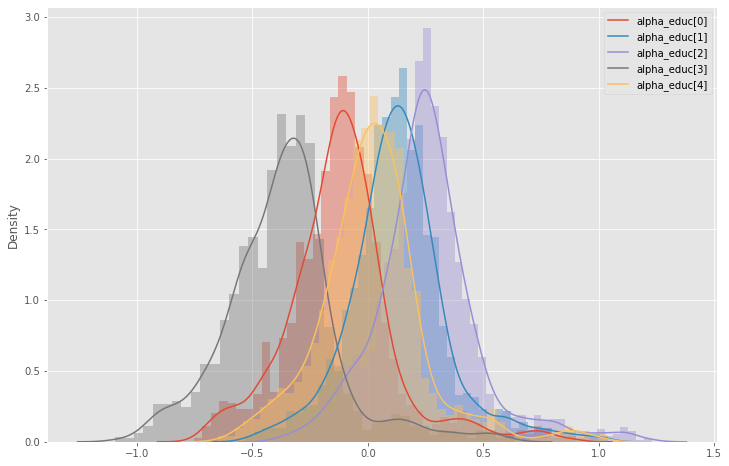

In [52]:
n_cat = 5
for c in range(n_cat):
    sns.distplot(hmc_samples.item()["alpha_educ"][:,c])
plt.legend(["alpha_educ[%d]" % c for c in range(n_cat)])
plt.show()

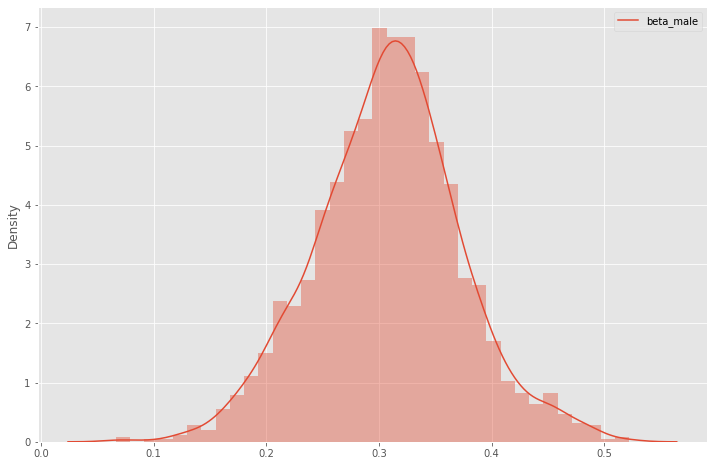

In [53]:
sns.distplot(hmc_samples.item()["beta_male"])
plt.legend(["beta_male"])
plt.show()

# 3) ANCESTRAL SAMPLING

In [54]:
def model_ancest_VI(X, states_x, obs=None):
    
    sigmas = pyro.sample("sigmas", dist.HalfCauchy(torch.ones(8)*5.))
    gammas = pyro.sample("gammas", dist.Normal(torch.zeros(7), 5.0))
    alpha_educ = pyro.sample("alpha_educ", dist.Normal(torch.zeros(5), sigmas[0]))
    alpha_eth = pyro.sample("alpha_eth", dist.Normal(torch.zeros(4), sigmas[1]))
    alpha_age = pyro.sample("alpha_age", dist.Normal(torch.zeros(6), sigmas[2]))
    alpha_male_eth = pyro.sample("alpha_male_eth", dist.Normal(torch.zeros((2,4)), sigmas[3]))
    alpha_educ_age = pyro.sample("alpha_educ_age", dist.Normal(torch.zeros((5,6)), sigmas[4]))
    alpha_educ_eth = pyro.sample("alpha_educ_eth", dist.Normal(torch.zeros((5,4)), sigmas[5]))

    beta_male = pyro.sample("beta_male", dist.Normal(0.,5.))
    with pyro.plate("data", size=len(X)):
        state = X[:,0].tolist()
        eth = X[:,1].tolist()
        male = X[:,2].tolist()
        male_t = X[:,2]
        age = X[:,3].tolist()
        educ = X[:,4].tolist()
        y = pyro.sample("y",dist.Bernoulli(torch.sigmoid(gammas[5] + gammas[6]* states_x[:,0][state] + gammas[states_x[:,1][state].tolist()]+ alpha_educ[educ] + alpha_eth[eth] + alpha_age[age]+ beta_male*male_t + alpha_male_eth[male, eth] + alpha_educ_age[educ,age] + alpha_educ_eth[educ, eth] )), obs= obs)
    return y

def model_ancest_MC(X, obs=None):
    
    sigmas = numpyro.sample("sigmas", ndist.HalfCauchy(5.), sample_shape = (8,))
    gammas = numpyro.sample("gammas", ndist.Normal(0., 5.), sample_shape = (7,))
    alpha_educ = numpyro.sample("alpha_educ", ndist.Normal(0., sigmas[0]), sample_shape = (5,))
    alpha_eth = numpyro.sample("alpha_eth", ndist.Normal(0., sigmas[1]), sample_shape = (4,))
    alpha_age = numpyro.sample("alpha_age", ndist.Normal(0., sigmas[2]), sample_shape = (6,))
    alpha_male_eth = numpyro.sample("alpha_male_eth", ndist.Normal(0., sigmas[3]), sample_shape = (2,4))
    alpha_educ_age = numpyro.sample("alpha_educ_age", ndist.Normal(0., sigmas[4]), sample_shape = (5,6))
    alpha_educ_eth = numpyro.sample("alpha_educ_eth", ndist.Normal(0., sigmas[5]), sample_shape = (5,4))
    
    beta_male = numpyro.sample("beta_male", ndist.Normal(0.,5.))
    with numpyro.plate("data", size = len(X)):
        state = X[:,0].tolist()
        eth = X[:,1].tolist()
        male = X[:,2].tolist()
        male_t = X[:,2]
        age = X[:,3].tolist()
        educ = X[:,4].tolist()
        y = numpyro.sample("y", ndist.Bernoulli(jax.nn.sigmoid(gammas[5] + gammas[6]* jnp.array(states_x[:,0][state]) + gammas[jnp.array(states_x[:,1][state],dtype = int)]+ alpha_educ[jnp.array(educ, dtype = int)] + alpha_eth[jnp.array(eth, dtype = int)] + alpha_age[jnp.array(age, dtype = int)] + alpha_male_eth[jnp.array(male, dtype = int), jnp.array(eth, dtype = int)] + alpha_educ_age[jnp.array(educ, dtype = int), jnp.array(age, dtype = int)] + alpha_educ_eth[jnp.array(educ, dtype = int), jnp.array(eth, dtype = int)] + beta_male*jnp.array(male_t))), obs= jnp.array(obs))
    return y


ancest_perc = 0.1 #0.66 # percentage of training data
split_point = int(ancest_perc*len(y))
perm = np.random.permutation(len(y))
ancest_ix = perm[:split_point]
X_ancest = X[ancest_ix]
states_ancest = X_ancest[:,0].int().tolist()
eth = X_ancest[:,1].int().tolist()
male = X_ancest[:,2].int().tolist()
male_t = X_ancest[:,2].numpy()
age = X_ancest[:,3].int().tolist()
educ = X_ancest[:,4].int().tolist()

y_ancest = []

sigmas = np.sqrt(np.arange(8)+1)
gammas_ancest = [None]*7
alpha_educ_ancest = [None]*5
alpha_eth_ancest = [None]*4
alpha_age_ancest = [None]*6
alpha_male_eth_ancest =  [[None]*4]*2 # np.zeros((2,4)) 
alpha_educ_age_ancest =  [[None]*6]*5 # np.zeros((5,6))
alpha_educ_eth_ancest =  [[None]*4]*5 # np.zeros((5,4))

for k in range(len(gammas_ancest)):
    gammas_ancest[k] = np.random.normal(0.5-k*0.2,0.1,size=len(states_ancest))
for k in range(len(alpha_educ_ancest)):
    alpha_educ_ancest[k] = np.random.normal(1.7 - k/3 ,0.4 *(k+1) ,size=len(states_ancest))
for k in range(len(alpha_eth_ancest)):
    alpha_eth_ancest[k] = np.random.normal(0.5 + k/3 ,2/(k+1) ,size=len(states_ancest))
for k in range(len(alpha_age_ancest)):
    alpha_age_ancest[k] = np.random.normal(-1.8 + k/2 ,0.1 * (k+1) ,size=len(states_ancest))
for k in range(len(alpha_male_eth_ancest)):
    for i in range(len(alpha_male_eth_ancest[k])):
        alpha_male_eth_ancest[k][i] = np.random.normal(-0.7 + k/5 + 0.3 - i/4 ,0.6 *(k+1) + 2/(i+1) ,size=len(states_ancest))
for k in range(len(alpha_educ_age_ancest)):
    for i in range(len(alpha_educ_age_ancest[k])):
        alpha_educ_age_ancest[k][i] = np.random.normal(0.8 - k/3 -2 + i/3 ,0.4 *(k+1) + 0.1 * (i+1) ,size=len(states_ancest))
for k in range(len(alpha_educ_eth_ancest)):
    for i in range(len(alpha_educ_eth_ancest[k])):
        alpha_educ_eth_ancest[k][i] = np.random.normal(0.3 + k/2 + 0.3 - i/5,0.4 *(k+1) + 2/(i+1),size=len(states_ancest))
beta_male_ancest = np.random.normal(-2,0.5,size=len(states_ancest))
for i,state in enumerate(states_ancest):
    y_ancest.append(np.round(sigmoid_n(gammas_ancest[5][i]+ gammas_ancest[6][i]* states_x[:,0][state]+ gammas_ancest[states_x[:,1][state].int().tolist()][i]  +alpha_educ_ancest[educ[i]][i]+ alpha_eth_ancest[eth[i]][i] + alpha_age_ancest[age[i]][i] +beta_male_ancest[i]*male_t[i] + alpha_male_eth_ancest[male[i]][eth[i]][i] + alpha_educ_age_ancest[educ[i]][age[i]][i] + alpha_educ_eth_ancest[educ[i]][eth[i]][i])))


In [55]:
len(y_ancest)

5981

Support in the artificial sample

In [56]:
sum(y_ancest)/len(y_ancest)

0.46931951178732656

Support in survey

In [57]:
float(y.mean())

0.43415817618370056

## VARIATIONAL INFERENCE

In [58]:
guide_ancest = train_SVI(torch.tensor(X_ancest).float(),torch.tensor(y_ancest).float(),states_x,model_ancest_VI)

[0] ELBO: 13392.3
[500] ELBO: 4086.4
[1000] ELBO: 4066.4
[1500] ELBO: 4012.6
[2000] ELBO: 3985.1
[2500] ELBO: 4027.5
[3000] ELBO: 3982.2
[3500] ELBO: 3976.4
[4000] ELBO: 3962.7
[4500] ELBO: 3971.2
[5000] ELBO: 3962.0
[5500] ELBO: 3960.1


In [59]:
samples_ancest, params_samples_ancest = sample_params(guide_ancest,torch.tensor(X_ancest).float(),states_x, torch.tensor(y_ancest).float(), model_ancest_VI)

(2000, 5)


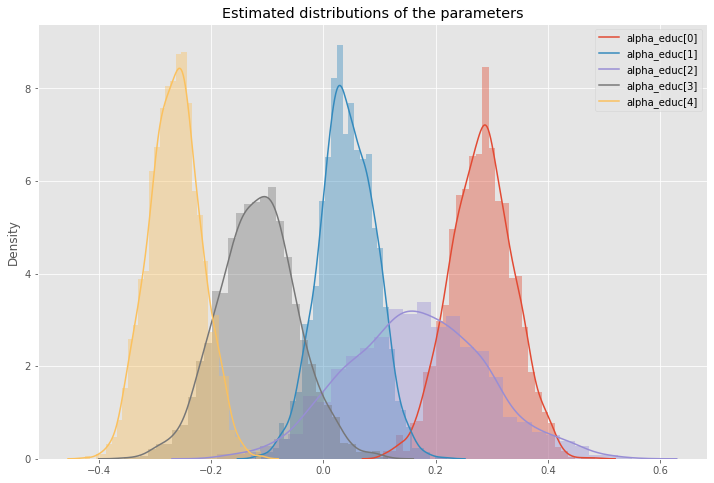

In [60]:
n_cat = 5
print(params_samples_ancest["alpha_educ"].shape)
for c in range(n_cat):
    sns.distplot(params_samples_ancest["alpha_educ"][:,c])
plt.legend(["alpha_educ[%d]" % c for c in range(n_cat)])
plt.title("Estimated distributions of the parameters")
plt.show()

In [61]:
print("True means of the parameters' distributions")
for k in alpha_educ_ancest:
    print(k.mean())

True means of the parameters' distributions
1.6880596366405356
1.3626559736686934
1.0550449004334668
0.7018858049105599
0.406452873110308


In [62]:
print("Accuracy on the ancestral sample:")
compute_accuracy(samples_ancest,torch.tensor(X_ancest).float(),torch.tensor(y_ancest).float(),states_x)

Accuracy on the ancestral sample:
predictions: [0. 1. 0. ... 1. 0. 1.]
true values: [1. 1. 0. ... 1. 0. 1.]
Accuracy: 0.6228055509112188


## MARKOV CHAIN MONTE CARLO

In [63]:
"""
import time
import jax
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
from jax import lax
t0 = time.time()

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model_ancest_MC)
mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=500, num_chains=1)
mcmc.run(rng_key_, X_ancest, y_ancest)

t_fin = time.time()

print("Total time: {0:.3f}m".format((t_fin - t0)/60))
"""

'\nimport time\nimport jax\nimport jax.numpy as jnp\nfrom jax import random, vmap\nfrom jax.scipy.special import logsumexp\nfrom jax import lax\nt0 = time.time()\n\nrng_key = random.PRNGKey(0)\nrng_key, rng_key_ = random.split(rng_key)\n\nnuts_kernel = NUTS(model=model_ancest_MC)\nmcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=500, num_chains=1)\nmcmc.run(rng_key_, X_ancest, y_ancest)\n\nt_fin = time.time()\n\nprint("Total time: {0:.3f}m".format((t_fin - t0)/60))\n'

In [64]:
#hmc_samples = {k: np.asarray(v) for k, v in mcmc.get_samples().items()}
#np.save('mcmc_ancest_posterior.npy',  hmc_samples)

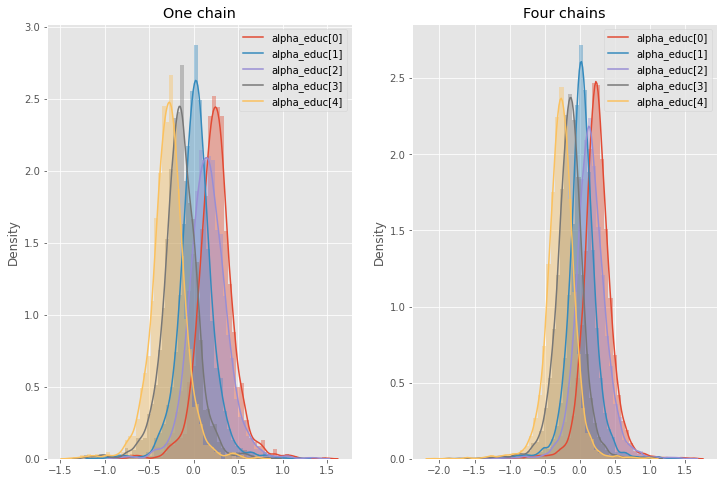

In [65]:
#hmc_samples = {k: v for k, v in mcmc.get_samples().items()}
hmc_samples = np.load('mcmc_ancest_posterior.npy', allow_pickle = True) 
hmc_samples_2 = np.load('mcmc_ancest_4_chains_posterior.npy', allow_pickle = True) 
params_hat_2 = {}
params_hat_2_2 = {}
params =["alpha_educ", "alpha_eth", "alpha_age", "gammas", "beta_male", "alpha_educ_age", "alpha_educ_eth", "alpha_male_eth"]
for param in params:
    params_hat_2[param] = hmc_samples.item()[param].mean(axis=0)
    params_hat_2_2[param] = hmc_samples_2.item()[param].mean(axis=0)
    
    
    
n_cat = 5
plt.subplot(1,2,1)
plt.title("One chain")
for c in range(n_cat):
    sns.distplot(hmc_samples.item()["alpha_educ"][:,c])
plt.legend(["alpha_educ[%d]" % c for c in range(n_cat)])
plt.subplot(1,2,2)
plt.title("Four chains")
for c in range(n_cat):
    sns.distplot(hmc_samples_2.item()["alpha_educ"][:,c])
plt.legend(["alpha_educ[%d]" % c for c in range(n_cat)])
plt.show();


In [66]:
print("True means of the parameters' distributions")
for k in alpha_educ_ancest:
    print(k.mean())

True means of the parameters' distributions
1.6880596366405356
1.3626559736686934
1.0550449004334668
0.7018858049105599
0.406452873110308


In [67]:
states_ancest = X_ancest[:,0].int().tolist()
eth = X_ancest[:,1].int().tolist()
male = X_ancest[:,2].int().tolist()
male_t = X_ancest[:,2].numpy()
age = X_ancest[:,3].int().tolist()
educ = X_ancest[:,4].int().tolist()



y_hat = np.round(sigmoid_n(params_hat_2["gammas"][5]+ params_hat_2["gammas"][6]* states_x[:,0][states_ancest]+ params_hat_2["gammas"][states_x[:,1][states_ancest].int().tolist()] +params_hat_2["alpha_educ"][educ]+ params_hat_2["alpha_eth"][eth] + params_hat_2["alpha_age"][age] + params_hat_2["alpha_male_eth"][male, eth] + params_hat_2["alpha_educ_age"][educ, age] + params_hat_2["alpha_educ_eth"][educ, eth] +params_hat_2["beta_male"]*male_t))
print("predictions:", y_hat)
print("true values:", np.array(y_ancest))

# evaluate prediction accuracy
print("Accuracy on the ancestral sample:", 1.0*np.sum(y_hat == y_ancest) / len(y_ancest))

predictions: [0. 1. 0. ... 1. 0. 1.]
true values: [1. 1. 0. ... 1. 0. 1.]
Accuracy on the ancestral sample: 0.6226383547901688


# 4) POSTSTRATIFICATION

Loading the poststratification table (all possible combinations of our features and corresponding number of US citizens belonging to each group)

In [68]:
post = pd.read_csv("Data/poststrat_df.csv")
categories = ["state", "eth", "male", "age", "educ"]
for category in categories:
    post[category+"_cat"] = post[category].astype('category').cat.codes
post.head()

,state,eth,male,age,educ,n,state_cat,eth_cat,male_cat,age_cat,educ_cat
0,AL,White,-0.5,18-29,No HS,23948,1,3,0,0,2
1,AL,White,-0.5,18-29,HS,59378,1,3,0,0,1
2,AL,White,-0.5,18-29,Some college,104855,1,3,0,0,4
3,AL,White,-0.5,18-29,4-Year College,37066,1,3,0,0,0
4,AL,White,-0.5,18-29,Post-grad,9378,1,3,0,0,3


In [69]:
states_x_n = states_x.numpy()

In [70]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def poststritify(params_samples, post, states_x_n):
    gammas = params_samples["gammas"]
    theta = 0
    prog = 0
    z_state = np.zeros(50)
    for state_i in range(50):
        update_progress(prog / 50)
        prog += 1
        for eth_i, eth in enumerate(params_samples["alpha_eth"].T):
            for age_i, age in enumerate(params_samples["alpha_age"].T):
                for educ_i, educ in enumerate(params_samples["alpha_educ"].T):
                    for male_i in [0,1]:
                        theta_sub = sigmoid(gammas[:, 5] + gammas[:,6]* states_x_n[:,0][state_i] + gammas[:,int(states_x_n[:,1][state_i])] + educ + eth + age + params_samples["alpha_educ_age"][:,educ_i,age_i] + params_samples["alpha_educ_eth"][:,educ_i,eth_i]+params_samples["beta_male"].squeeze()*male_i)
                        n = post[(post["state_cat"] == state_i) & (post["age_cat"] == age_i) & (post["eth_cat"] == eth_i) & (post["educ_cat"] == educ_i) & (post["male_cat"] == male_i)]["n"].values[0]
                        theta += theta_sub * n
                        z_state[state_i] = z_state[state_i] + theta_sub.mean() * n
    update_progress(1)
    theta = theta / post["n"].sum()
    z_state = z_state / post.groupby("state")["n"].sum().values
    return theta, z_state
theta, z_state = poststritify(params_samples, post, states_x_n)

Progress: [####################] 100.0%


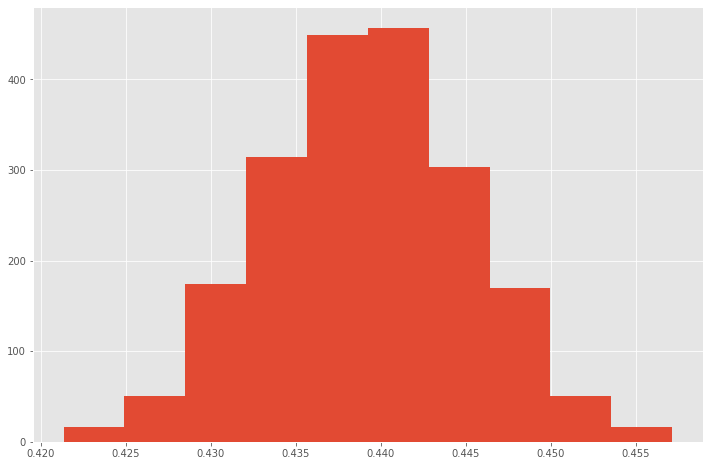

In [71]:
plt.hist(theta);
plt.show();

In [72]:
print("Survey mean support: ", y_true.sum()/len(y_true))
print("Survey support std: ", math.sqrt(y_true.mean()*(1-y_true.mean())/len(y_true)))
print("Size of the Survey:  ", len(y_true))
print("")
print("MRP mean support estimate: ", theta.mean())
print("MRP std: ", theta.std())
print("Population size: ", post["n"].sum())

Survey mean support:  0.4341581675305133
Survey support std:  0.002026677347449802
Size of the Survey:   59810

MRP mean support estimate:  0.43918663200114993
MRP std:  0.0059346027636922915
Population size:  228443347


In [73]:
#!pip install -q geopandas==0.3.0
#!pip install -q pyshp==1.2.10
#!pip install -q shapely==1.6.3
#!pip install -q plotly-geo
#!conda install -y -c plotly plotly-orca

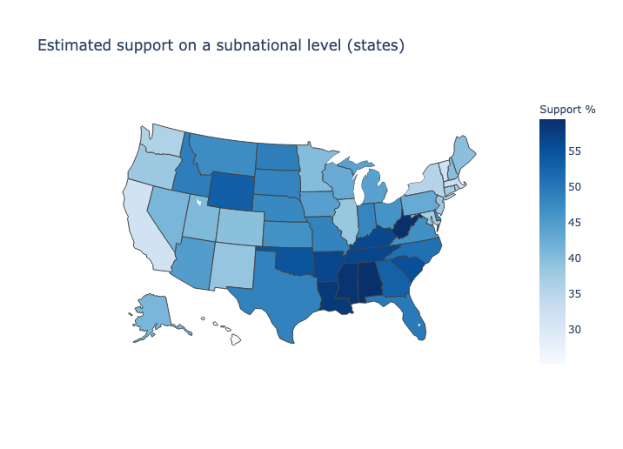

In [74]:
import matplotlib.image as mpimg
"""
import plotly.graph_objects as go


fig = go.Figure(data=go.Choropleth(
    locations=states["states"], # Spatial coordinates
    z = z_state.astype(float) * 100, # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Blues',
    colorbar_title = "Support %",
))

fig.update_layout(
    title_text = 'Estimated support on a subnational level (states)',
    geo_scope='usa', # limite map scope to USA
)

fig.show()
fig.write_image('estimated_usa.png')

"""
plt.imshow(mpimg.imread('estimated_usa.png'));
plt.axis('off');

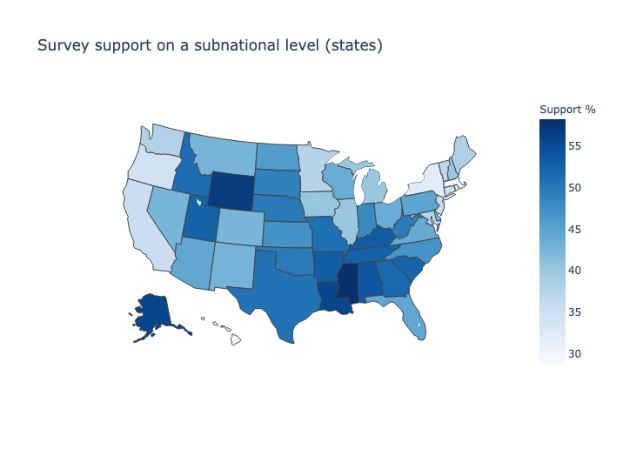

In [75]:
"""
fig = go.Figure(data=go.Choropleth(
    locations=states["states"], # Spatial coordinates
    z = df.groupby("state")["abortion"].mean().values.astype(float) * 100, # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Blues',
    colorbar_title = "Support %",
))

fig.update_layout(
    title_text = 'Survey support on a subnational level (states)',
    geo_scope='usa', # limite map scope to USA
)

fig.show()
fig.write_image('survey_usa.png')
"""
plt.imshow(mpimg.imread('survey_usa.png'));
plt.axis('off');

# 5) SMALL SAMPLE & NON REPRESENTATIVE SAMPLE

In [76]:
small_sample = df.sample(5000, random_state=1)
small_sample

,abortion,state,eth,male,age,educ,state_cat,eth_cat,male_cat,age_cat,educ_cat
11159,0,VA,White,0.5,50-59,Post-grad,44,3,1,3,3
36809,1,FL,White,-0.5,70+,HS,8,3,0,5,1
6633,0,CA,White,-0.5,70+,Some college,4,3,0,5,4
53044,1,DE,White,0.5,60-69,4-Year College,7,3,1,4,0
33525,0,MA,White,-0.5,18-29,HS,18,3,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
40640,1,SC,White,-0.5,60-69,HS,39,3,0,4,1
10855,1,AZ,White,-0.5,70+,Some college,3,3,0,5,4
21053,1,LA,White,-0.5,30-39,HS,17,3,0,1,1
40551,1,NH,White,-0.5,18-29,Some college,29,3,0,0,4


Non representative sample is sampled from the complete survey, but we sample specific groups with higher probabilities (old white males) 

In [77]:
df_3 = df.merge(states,left_on = "state", right_on = "states")
df_3 = df_3.drop("states", axis = 1)
weights = (5*df_3.rep_sup + (df_3.age=="18-29")*0.5 + (df_3.age=="30-39")*1 +(df_3.age=="40-49")*2 + (df_3.age=="50-59")*4 + (df_3.age=="60-69")*6 + (df_3.age=="70+")*8 + (df_3.male==0.5)*20 +(df_3.eth=="White")*1.05)
biased_sample = df_3.sample(5000, random_state=1, weights = weights)
biased_sample

,abortion,state,eth,male,age,educ,state_cat,eth_cat,male_cat,age_cat,educ_cat,rep_sup,region
25311,1,IN,White,0.5,50-59,4-Year College,14,3,1,3,0,0.56,midwest
43299,1,WA,White,0.5,70+,Post-grad,46,3,1,5,3,0.36,west
7,1,MD,White,0.5,70+,HS,19,3,1,5,1,0.33,northeast
18216,1,PA,White,0.5,50-59,Some college,37,3,1,3,4,0.48,northeast
9095,1,CA,Black,0.5,40-49,Some college,4,0,1,2,4,0.31,west
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21729,1,NY,White,0.5,70+,HS,33,3,1,5,1,0.36,northeast
53831,0,MA,Other,0.5,60-69,4-Year College,18,2,1,4,0,0.32,northeast
25297,0,IN,White,-0.5,50-59,HS,14,3,0,3,1,0.56,midwest
56011,0,IA,White,0.5,50-59,4-Year College,11,3,1,3,0,0.51,midwest


In [78]:
mat_small = small_sample.iloc[:,6:11].values
X_small = mat_small
X_small = torch.tensor(X_small).float()
y_small = small_sample.iloc[:,0].values
y_small = torch.tensor(y_small).float()
print(X_small.shape)
print(states_x.shape)
print(y_small)

torch.Size([5000, 5])
torch.Size([50, 2])
tensor([0., 1., 0.,  ..., 1., 1., 0.])


In [79]:
mat_biased = biased_sample.iloc[:,6:11].values
X_biased = mat_biased
X_biased = torch.tensor(X_biased).float()
y_biased = biased_sample.iloc[:,0].values
y_biased = torch.tensor(y_biased).float()
print(X_biased.shape)
print(states_x.shape)
print(y_biased)

torch.Size([5000, 5])
torch.Size([50, 2])
tensor([1., 1., 1.,  ..., 0., 0., 1.])


In [80]:
#guide_small = train_SVI(X_small,y_small,states_x,model)
#guide_biased = train_SVI(X_biased,y_biased,states_x,model)

In [81]:
saved_model_dict_small = torch.load("mymodel_small.pt")
guide_small = saved_model_dict['guide']
saved_model_dict_biased = torch.load("mymodel_biased.pt")
guide_biased = saved_model_dict['guide']
samples_small, params_samples_small = sample_params(guide_small, X,states_x, y,model)
samples_biased, params_samples_biased = sample_params(guide_biased, X,states_x, y,model)

In [82]:
#torch.save({"guide" : guide_small}, "mymodel_small.pt")
#torch.save({"guide" : guide_biased}, "mymodel_biased.pt")

In [83]:
compute_accuracy(samples_small,X_small,y_small,states_x)

predictions: [0. 1. 0. ... 1. 0. 0.]
true values: [0. 1. 0. ... 1. 1. 0.]
Accuracy: 0.6056


In [84]:
compute_accuracy(samples_biased,X_biased,y_biased,states_x)

predictions: [1. 0. 0. ... 0. 1. 1.]
true values: [1. 1. 1. ... 0. 0. 1.]
Accuracy: 0.5846


In [85]:
theta_small, _ = poststritify(params_samples_small, post, states_x_n)
theta_biased, _ = poststritify(params_samples_biased, post, states_x_n)

Progress: [####################] 100.0%


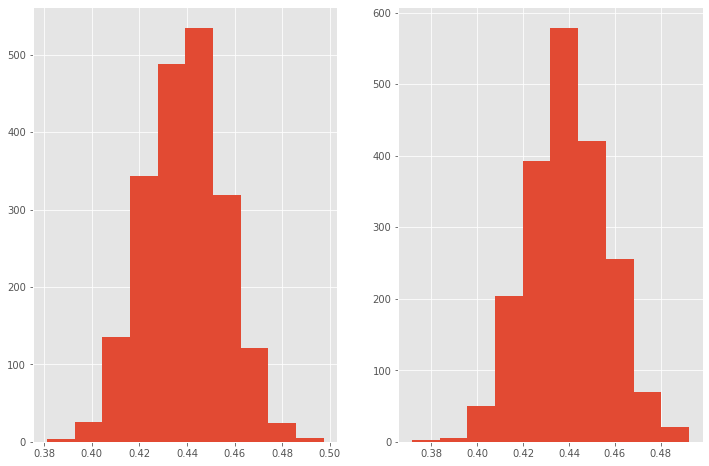

In [86]:
plt.subplot(1,2,1)
plt.hist(theta_small)
plt.subplot(1,2,2)
plt.hist(theta_biased);
plt.show();

In [87]:
print("Survey small sample mean support: ", y_small.numpy().sum()/len(y_small.numpy()))
print("Survey small sample support std: ", math.sqrt(y_small.numpy().mean()*(1-y_small.numpy().mean())/len(y_small.numpy())))
print("Size of the Survey small sample:  ", len(y_small.numpy()))
print("")
print("Survey biased sample mean support: ", y_biased.numpy().sum()/len(y_biased.numpy()))
print("Survey  biased sample support std: ", math.sqrt(y_biased.numpy().mean()*(1-y_biased.numpy().mean())/len(y_biased.numpy())))
print("Size of the Survey biased sample:  ", len(y_biased.numpy()))
print("")
print("MRP mean support estimate from the small sample: ", theta_small.mean())
print("MRP std: ", theta_small.std())
print("Population size: ", post["n"].sum())
print("")
print("MRP mean support estimate from the biased sample: ", theta_biased.mean())
print("MRP std: ", theta_biased.std())
print("Population size: ", post["n"].sum())

Survey small sample mean support:  0.4306
Survey small sample support std:  0.007002622912394368
Size of the Survey small sample:   5000

Survey biased sample mean support:  0.473
Survey  biased sample support std:  0.0070607506606488605
Size of the Survey biased sample:   5000

MRP mean support estimate from the small sample:  0.43891414802287937
MRP std:  0.016495558279819068
Population size:  228443347

MRP mean support estimate from the biased sample:  0.4394917502062339
MRP std:  0.017032531147047794
Population size:  228443347


# 6)  NON-CENSUS VARIABLE

Now we add a feature "party", which was also obtained in the survey but is not available for the whole population.

In [88]:
df_n_0 = pd.read_csv("Data/cces_all_clean_2.csv", index_col=0)
states = pd.read_excel("Data/states.xlsx")
states = states.rename(columns={'republican support percentage':"rep_sup"})
states.head()

,states,rep_sup,region
0,AK,0.51,west
1,AL,0.62,southeast
2,AR,0.60,southeast
3,AZ,0.48,southwest
4,CA,0.31,west


In [89]:
df_n = df_n_0.merge(states, left_on = "state", right_on = "states")
df_n.drop('states', inplace=True, axis=1)
for category in categories+["party"]:
    df_n[category+"_cat"] = df_n[category].astype('category').cat.codes
df_n.head()

,abortion,state,eth,male,age,educ,party,rep_sup,region,state_cat,eth_cat,male_cat,age_cat,educ_cat,party_cat
0,1,MD,Other,-0.5,50-59,Some college,Independent,0.33,northeast,19,2,0,3,4,1
1,0,MD,White,-0.5,18-29,Some college,Independent,0.33,northeast,19,3,0,0,4,1
2,0,MD,White,0.5,30-39,Post-grad,Independent,0.33,northeast,19,3,1,1,3,1
3,1,MD,Other,-0.5,60-69,Post-grad,Republican,0.33,northeast,19,2,0,4,3,2
4,0,MD,White,0.5,70+,Post-grad,Democrat,0.33,northeast,19,3,1,5,3,0


In [90]:
post_n = pd.read_csv("Data/poststrat_df.csv")
categories = ["state", "eth", "male", "age", "educ","region"]
post_n = post_n.merge(states, left_on = "state", right_on = "states")
post_n.drop('states', inplace=True, axis=1)
for category in categories:
    post_n[category+"_cat"] = post_n[category].astype('category').cat.codes
post_n.head()

,state,eth,male,age,educ,n,rep_sup,region,state_cat,eth_cat,male_cat,age_cat,educ_cat,region_cat
0,AL,White,-0.5,18-29,No HS,23948,0.62,southeast,1,3,0,0,2,2
1,AL,White,-0.5,18-29,HS,59378,0.62,southeast,1,3,0,0,1,2
2,AL,White,-0.5,18-29,Some college,104855,0.62,southeast,1,3,0,0,4,2
3,AL,White,-0.5,18-29,4-Year College,37066,0.62,southeast,1,3,0,0,0,2
4,AL,White,-0.5,18-29,Post-grad,9378,0.62,southeast,1,3,0,0,3,2


## NON REPRESENTATIVE SAMPLE

In [91]:
weights = (0.75 * (df_n.party == "Independent") + 0.5*(df_n.party == "Republican") + (df_n.party == "Democrat"))
non_rep_sample = df_n.sample(5000, random_state=1, weights = weights)
non_rep_sample

,abortion,state,eth,male,age,educ,party,rep_sup,region,state_cat,eth_cat,male_cat,age_cat,educ_cat,party_cat
24768,1,IN,White,0.5,30-39,4-Year College,Republican,0.56,midwest,14,3,1,1,0,2
43102,0,WA,Other,-0.5,18-29,Post-grad,Independent,0.36,west,46,2,0,0,3,1
7,1,MD,White,0.5,70+,HS,Independent,0.33,northeast,19,3,1,5,1,1
18032,0,PA,White,-0.5,40-49,Some college,Democrat,0.48,northeast,37,3,0,2,4,0
8637,0,CA,Hispanic,-0.5,30-39,No HS,Democrat,0.31,west,4,1,0,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59273,1,WY,Other,-0.5,40-49,Post-grad,Independent,0.67,west,49,2,0,2,3,1
57501,0,NM,White,-0.5,40-49,4-Year College,Democrat,0.40,southwest,31,3,0,2,0,0
13952,0,GA,Black,-0.5,60-69,HS,Republican,0.50,southeast,9,0,0,4,1,2
13444,1,AL,White,-0.5,18-29,4-Year College,Republican,0.62,southeast,1,3,0,0,0,2


In [92]:
non_rep_sample.abortion.sum()/5000

0.3724

Now we can select a non representative sample based on the "party" affiliation and see how our old MRP model performs. (Above we can see that the opinion of the sample is clearly biased compared with the resulting opinion of the survey - 43% )

In [93]:
mat_non_rep = non_rep_sample.iloc[:,[9,10,11,12,13]].values
X_non_rep = mat_non_rep
X_non_rep = torch.tensor(X_non_rep).float()
y_non_rep = non_rep_sample.iloc[:,0].values
y_non_rep = torch.tensor(y_non_rep).float()

In [94]:
guide_non_rep = train_SVI(X_non_rep,y_non_rep,states_x,model)

[0] ELBO: 8806.6
[500] ELBO: 3481.9
[1000] ELBO: 3400.5
[1500] ELBO: 3410.4
[2000] ELBO: 3332.6
[2500] ELBO: 3378.9
[3000] ELBO: 3360.2
[3500] ELBO: 3320.8
[4000] ELBO: 3348.2
[4500] ELBO: 3350.3
[5000] ELBO: 3360.6
[5500] ELBO: 3339.2


In [95]:
samples_non_rep, params_samples_non_rep = sample_params(guide_non_rep, X,states_x, y,model)
compute_accuracy(samples_non_rep,X_non_rep,y_non_rep,states_x)

predictions: [0. 0. 0. ... 0. 0. 0.]
true values: [1. 0. 1. ... 0. 1. 1.]
Accuracy: 0.627


In [96]:
theta_non_rep, _ = poststritify(params_samples_non_rep, post, states_x_n)

Progress: [####################] 100.0%


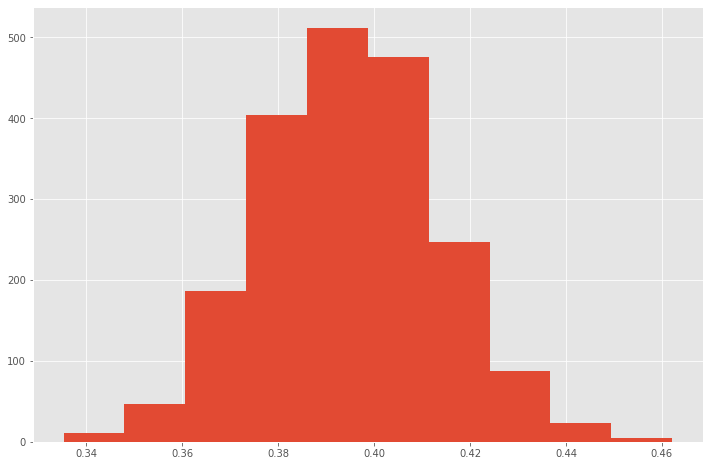

In [97]:
plt.hist(theta_non_rep);

It can be seen that in this case the poststratification did not correct for the bias that we introduced with the non representative sample.

In [98]:
print("Survey biased sample mean support: ", non_rep_sample.abortion.sum()/len(non_rep_sample.abortion))
print("Survey  biased sample support std: ", math.sqrt(non_rep_sample.abortion.mean()*(1-non_rep_sample.abortion.mean())/len(non_rep_sample.abortion)))
print("Size of the Survey biased sample:  ", len(non_rep_sample.abortion))
print("")
print("MRP mean support estimate from the biased sample: ", theta_non_rep.mean())
print("MRP std: ", theta_non_rep.std())
print("Population size: ", post["n"].sum())
print("")
print("Survey mean support: ", y.numpy().sum()/len(y.numpy()))
print("Survey support std: ", math.sqrt(y.numpy().mean()*(1-y.numpy().mean())/len(y.numpy())))
print("Size of the Survey:  ", len(y.numpy()))
print("")

Survey biased sample mean support:  0.3724
Survey  biased sample support std:  0.006836932645565554
Size of the Survey biased sample:   5000

MRP mean support estimate from the biased sample:  0.39484843485505405
MRP std:  0.01848572562948352
Population size:  228443347

Survey mean support:  0.4341581675305133
Survey support std:  0.002026677347449802
Size of the Survey:   59810



## PREDICTING THE NON CENSUS VARIABLE

We saw that we should include the non-census variable into our model, if we want to predict correctly (even from biased surveys). First, we fit a model to predict the "party" feature based on the "old" features: "state" - "republican support" and "region" , "education", "age", "ethnicity", "gender".

In [99]:
mat = df_n.iloc[:,9:].values
X = mat
X = torch.tensor(X).float()
y_cat = df_n["party_cat"].values
y_cat = torch.tensor(y_cat).float()

### BASELINE - Logistic Regression

In [100]:
category_columns = ["state", "eth", "male", "age", "educ", "region"]
df_n_2 = pd.read_csv("Data/cces_all_clean_2.csv", index_col=0)
df_n_2 = df_n_2.merge(states, left_on = "state", right_on = "states")
df_n_2.drop('states', inplace=True, axis=1)
for col in category_columns:
    df_n_2[col] = df_n_2[col].astype('category')
df_regr = pd.get_dummies(df_n_2, columns=category_columns, drop_first=True)
    
train_perc = 1 # percentage of training data
split_point = int(train_perc*len(y_cat))
perm = np.random.permutation(len(y_cat))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = df_regr.iloc[:,2:].values[ix_train,:]
X_test = df_regr.iloc[:,2:].values[ix_test,:]
y_train = y_cat[ix_train]
y_test = y_cat[ix_test]
y_test = y_train
X_test = X_train
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

regr = LogisticRegression()
regr.fit(X_train, y_train)
y_hat = regr.predict(X_test)


print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test.numpy()) / len(y_test.numpy()))

num train: 59756
num test: 59756
predictions: [1. 1. 2. ... 0. 0. 0.]
true values: tensor([2., 2., 0.,  ..., 0., 0., 0.])
Accuracy: 0.4628823883794096


### VARIATIONAL INFERENCE

In [101]:
from torch.nn.functional import softmax
def model_3(X, states_x, obs=None):
    n_cat = 3
    sigmas = pyro.sample("sigmas", dist.HalfCauchy(torch.ones(8)*5.))
    gammas = pyro.sample("gammas", dist.Normal(torch.zeros((7,n_cat)), 5.0))
    alpha_educ = pyro.sample("alpha_educ", dist.Normal(torch.zeros((5,n_cat)), sigmas[0]))
    alpha_eth = pyro.sample("alpha_eth", dist.Normal(torch.zeros((4,n_cat)), sigmas[1]))
    alpha_age = pyro.sample("alpha_age", dist.Normal(torch.zeros((6,n_cat)), sigmas[2]))
    alpha_male_eth = pyro.sample("alpha_male_eth", dist.Normal(torch.zeros((2,4,n_cat)), sigmas[3]))
    alpha_educ_age = pyro.sample("alpha_educ_age", dist.Normal(torch.zeros((5,6,n_cat)), sigmas[4]))
    alpha_educ_eth = pyro.sample("alpha_educ_eth", dist.Normal(torch.zeros((5,4,n_cat)), sigmas[5]))

    
    beta_male = pyro.sample("beta_male", dist.Normal(torch.zeros(n_cat),5.))
    with pyro.plate("data", size=len(X), subsample_size=1000) as ind:
        state = X[ind,0].tolist()
        eth = X[ind,1].tolist()
        male = X[ind,2].tolist()
        male_t = X[ind,2]
        age = X[ind,3].tolist()
        educ = X[ind,4].tolist()

        theta = gammas[5][:, np.newaxis] + gammas[6][:, np.newaxis]* torch.stack([states_x[:,0][state], states_x[:,0][state], states_x[:,0][state]]) + gammas[states_x[:,1][state].tolist()].T+ alpha_educ[educ].T + alpha_eth[eth].T + alpha_age[age].T + alpha_male_eth[male, eth].T + alpha_educ_age[educ,age].T + alpha_educ_eth[educ, eth].T + beta_male[:, np.newaxis]* torch.stack([male_t,male_t,male_t])
        y = pyro.sample("y",dist.Categorical(softmax(theta.T, dim= 1)), obs= obs[ind])
    return y

In [102]:
#guide_cat = train_SVI(X,y_cat,states_x,model_3)

In [103]:
#torch.save({"guide" : guide_cat}, "mymodel_party.pt")
#pyro.get_param_store().save("mymodelparams_party.pt")
saved_model_dict = torch.load("mymodel_party.pt")
guide_cat = saved_model_dict['guide']
pyro.get_param_store().load("mymodelparams_party.pt")

In [104]:
def compute_cat_accuracy(samples,X,y,states_x):
    params_hat = {}
    params =["alpha_educ", "alpha_eth", "alpha_age", "gammas", "beta_male", "alpha_educ_age", "alpha_educ_eth", "alpha_male_eth"]
    # extract expected values of the parameters
    for param in params:
        params_hat[param] = samples[param].mean(axis=0).detach().numpy()
    state = X[:,0].int().tolist()
    eth = X[:,1].int().tolist()
    male = X[:,2].int().tolist()
    male_t = X[:,2].numpy()
    age = X[:,3].int().tolist()
    educ = X[:,4].int().tolist()
    
    y_hat = params_hat["gammas"][5][:, np.newaxis]+ params_hat["gammas"][6][:, np.newaxis]* np.stack([states_x[:,0][state],states_x[:,0][state],states_x[:,0][state]])+ params_hat["gammas"][states_x[:,1][state].int().tolist()].T +params_hat["alpha_educ"][educ].T+ params_hat["alpha_eth"][eth].T + params_hat["alpha_age"][age].T + params_hat["alpha_male_eth"][male, eth].T + params_hat["alpha_educ_age"][educ, age].T + params_hat["alpha_educ_eth"][educ, eth].T +params_hat["beta_male"][:, np.newaxis]*np.stack([male_t,male_t,male_t])
    y_hat = softmax(torch.from_numpy(y_hat.T), dim= 1).numpy()
    y_true = y.numpy()
    print("predictions:", np.argmax(y_hat,1))
    print("true values:", y_true)

    # evaluate prediction accuracy
    print("Accuracy:", 1.0*np.sum(np.argmax(y_hat,1) == y_true) / len(y_true))

In [105]:
#guide_cat = saved_model_dict['guide']
#pyro.get_param_store().load("mymodelparams.pt")
samples, params_samples = sample_params(guide_cat, X,states_x, y_cat,model_3, num = 500)
compute_cat_accuracy(samples,X,y_cat,states_x)

predictions: [0 0 0 ... 1 1 0]
true values: [1. 1. 1. ... 1. 1. 1.]
Accuracy: 0.45747707343195665


#### The ratio of the 3 "party" classes

In [106]:
for i in range(3):
    print(len(y_cat[y_cat==i])/len(y_cat))

0.35740344065867863
0.37517571457259524
0.26742084476872613


## EXTENDING THE POSTSTRATIFICATION TABLE

Now that we are able to predict the "party" we extend the poststratification table with this variable and calculate the new number of people belonging to each group.

In [107]:
a = post_n.copy()
b = post_n.copy()
c = post_n.copy()
a["party"] = 0
b["party"] = 1
c["party"] = 2

frames = [a,b,c]
post_n = pd.concat(frames)
post_n = post_n.reset_index()
post_n["new_n"] = -1
post_n.head()

,index,state,eth,male,age,educ,n,rep_sup,region,state_cat,eth_cat,male_cat,age_cat,educ_cat,region_cat,party,new_n
0,0,AL,White,-0.5,18-29,No HS,23948,0.62,southeast,1,3,0,0,2,2,0,-1
1,1,AL,White,-0.5,18-29,HS,59378,0.62,southeast,1,3,0,0,1,2,0,-1
2,2,AL,White,-0.5,18-29,Some college,104855,0.62,southeast,1,3,0,0,4,2,0,-1
3,3,AL,White,-0.5,18-29,4-Year College,37066,0.62,southeast,1,3,0,0,0,2,0,-1
4,4,AL,White,-0.5,18-29,Post-grad,9378,0.62,southeast,1,3,0,0,3,2,0,-1


We also want to propagate the uncertainty of the prediction of the "party" and therefore we create 500 poststratification tables. (500 is the number of samples that we receive for each prediciton)

In [108]:
post_n_tables = []
for i in range(500):
    post_n_tables.append(post_n.copy())

In [109]:
def extend_non_census_var(samples, post, states_x):
    params =["alpha_educ", "alpha_eth", "alpha_age", "gammas", "beta_male", "alpha_educ_age", "alpha_educ_eth", "alpha_male_eth"]
    params_samples = {}
    for param in params:
        params_samples[param] = torch.from_numpy(samples[param])
    
    gammas = params_samples["gammas"]
    alpha_educ = params_samples["alpha_educ"]
    alpha_eth = params_samples["alpha_eth"]
    alpha_age = params_samples["alpha_age"]
    alpha_educ_age = params_samples["alpha_educ_age"]
    alpha_educ_eth = params_samples["alpha_educ_eth"]
    alpha_male_eth = params_samples["alpha_male_eth"]
    beta_male = params_samples["beta_male"]
    
    theta = 0
    for ind in post[0].index:
        update_progress(ind / len(post[0].index))
        state_i = post[0]["state_cat"][ind]
        eth_i = post[0]["eth_cat"][ind]
        age_i = post[0]["age_cat"][ind]
        educ_i = post[0]["educ_cat"][ind]
        male_i = post[0]["male_cat"][ind]
        
        theta_sub = gammas[:,5] + gammas[:,6]* states_x[:,0][state_i] + gammas[:,states_x[:,1][state_i].long(),:]+ alpha_educ[:,educ_i] + alpha_eth[:,eth_i] + alpha_age[:,age_i] + alpha_male_eth[:,male_i, eth_i] + alpha_educ_age[:,educ_i,age_i] + alpha_educ_eth[:,educ_i, eth_i] + beta_male*male_i

        theta_sub = softmax(theta_sub.T, dim= 0)
        n = post[0]["n"][ind]
        party = post[0]["party"][ind]
        for i in range(len(post)):
            post[i]["new_n"][ind] = n*theta_sub[party][i]
    update_progress(1)  
    return theta, post
#theta, post_mod = extend_non_census_var(params_samples, post_n_tables, states_x)

In [110]:
#new_ns = np.array([post.new_n.values for post in post_mod], dtype = np.int32)

In [111]:
#np.save("n_for_500_post_tables",new_ns)

In [112]:
new_ns = np.load("n_for_500_post_tables.npy")

In [113]:
for n, p in zip(new_ns, post_n_tables):
    p.new_n = n

# Non-census MRP with partisanship as a predictor

In [114]:
def model_non_census(X, states_x, obs=None):
    
    sigmas = pyro.sample("sigmas", dist.HalfCauchy(torch.ones(8)*5.))
    gammas = pyro.sample("gammas", dist.Normal(torch.zeros(7), 5.0))
    alpha_educ = pyro.sample("alpha_educ", dist.Normal(torch.zeros(5), sigmas[0]))
    alpha_eth = pyro.sample("alpha_eth", dist.Normal(torch.zeros(4), sigmas[1]))
    alpha_age = pyro.sample("alpha_age", dist.Normal(torch.zeros(6), sigmas[2]))
    alpha_male_eth = pyro.sample("alpha_male_eth", dist.Normal(torch.zeros((2,4)), sigmas[3]))
    alpha_educ_age = pyro.sample("alpha_educ_age", dist.Normal(torch.zeros((5,6)), sigmas[4]))
    alpha_educ_eth = pyro.sample("alpha_educ_eth", dist.Normal(torch.zeros((5,4)), sigmas[5]))
    

    alpha_party = pyro.sample("alpha_party", dist.Normal(torch.zeros(3), sigmas[6]))

    
    beta_male = pyro.sample("beta_male", dist.Normal(0.,5.))
    with pyro.plate("data", size=len(X), subsample_size=1000) as ind:
        state = X[ind,0].tolist()
        eth = X[ind,1].tolist()
        male = X[ind,2].tolist()
        male_t = X[ind,2]
        age = X[ind,3].tolist()
        educ = X[ind,4].tolist()
        party = X[ind,5].tolist()
        y = pyro.sample("y",dist.Bernoulli(torch.sigmoid(alpha_party[party] + gammas[5] + gammas[6]* states_x[:,0][state] + gammas[states_x[:,1][state].tolist()]+ alpha_educ[educ] + alpha_eth[eth] + alpha_age[age] + alpha_male_eth[male, eth] + alpha_educ_age[educ,age] + alpha_educ_eth[educ, eth] + beta_male*male_t)), obs= obs[ind])
    return y

The non-census data is still the same non-representative sample only with the "party" feature

In [115]:
mat_non_census = non_rep_sample.iloc[:,[9,10,11,12,13,14]].values
X_non_census = mat_non_census
X_non_census = torch.tensor(X_non_census).float()

y_non_census = non_rep_sample.iloc[:,0].values
y_non_census = torch.tensor(y_non_census).float()
print(X_non_census.shape)
print(states_x.shape)
print(y_non_census)

torch.Size([5000, 6])
torch.Size([50, 2])
tensor([1., 0., 1.,  ..., 0., 1., 1.])


In [116]:
guide_non_census = train_SVI(X_non_census,y_non_census,states_x,model_non_census)

[0] ELBO: 8377.7
[500] ELBO: 3091.8
[1000] ELBO: 3022.8
[1500] ELBO: 3002.6
[2000] ELBO: 2972.2
[2500] ELBO: 2934.6
[3000] ELBO: 2970.7
[3500] ELBO: 3019.5
[4000] ELBO: 2981.7
[4500] ELBO: 2940.8
[5000] ELBO: 2959.2
[5500] ELBO: 2914.3


In [117]:
from pyro.infer import Predictive
def sample_params_non_census(guide,X,states_x, y, model, num = 2000):
    predictive = Predictive(model, guide=guide, num_samples=num,
                            return_sites=("alpha_educ", "alpha_eth", "alpha_age", "beta_male", "alpha_educ_age", "alpha_educ_eth", "alpha_male_eth", "gammas", "y", "alpha_party"))
    samples = predictive(X,states_x, y)
    params =["alpha_educ", "alpha_eth", "alpha_age", "gammas", "beta_male", "alpha_educ_age", "alpha_educ_eth", "alpha_male_eth", "alpha_party"]
    params_samples = {}
    for param in params:
        params_samples[param] = samples[param].detach().numpy()
    return samples, params_samples

# make predictions for the train set
def sigmoid_n(x):
    x = x.numpy()
    return 1 / (1 + np.exp(-x))
def compute_accuracy_non_census(samples,X,y,states_x):
    params_hat = {}
    params =["alpha_educ", "alpha_eth", "alpha_age", "gammas", "beta_male", "alpha_educ_age", "alpha_educ_eth", "alpha_male_eth","alpha_party"]
    # extract expected values of the parameters
    for param in params:
        params_hat[param] = samples[param].mean(axis=0).detach().numpy()
    state = X[:,0].int().tolist()
    eth = X[:,1].int().tolist()
    male = X[:,2].int().tolist()
    male_t = X[:,2].numpy()
    age = X[:,3].int().tolist()
    educ = X[:,4].int().tolist()
    party = X[:,5].int().tolist()
    y_hat = np.round(sigmoid_n(torch.from_numpy(params_hat["alpha_party"][party]) + params_hat["gammas"][5]+ params_hat["gammas"][6]* states_x[:,0][state]+ params_hat["gammas"][states_x[:,1][state].int().tolist()] +params_hat["alpha_educ"][educ]+ params_hat["alpha_eth"][eth] + params_hat["alpha_age"][age] + params_hat["alpha_male_eth"][male, eth] + params_hat["alpha_educ_age"][educ, age] + params_hat["alpha_educ_eth"][educ, eth] +params_hat["beta_male"]*male_t))
    y_true = y.numpy()
    print("predictions:", y_hat)
    print("true values:", y_true)

    # evaluate prediction accuracy
    print("Accuracy:", 1.0*np.sum(y_hat == y_true) / len(y_true))
    
samples_non_census, params_samples_non_census = sample_params_non_census(guide_non_census, X_non_census,states_x, y_non_census,model_non_census, 500)
compute_accuracy_non_census(samples_non_census,X_non_census,y_non_census,states_x)

predictions: [1. 0. 0. ... 1. 1. 0.]
true values: [1. 0. 1. ... 0. 1. 1.]
Accuracy: 0.7028


In [118]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def poststritify_non_census_var_2(samples, post, states_x):
    params =["alpha_educ", "alpha_eth", "alpha_age", "gammas", "beta_male", "alpha_educ_age", "alpha_educ_eth", "alpha_male_eth", "alpha_party"]
    params_samples = {}
    for param in params:
        params_samples[param] = torch.from_numpy(samples[param])
    
    gammas = params_samples["gammas"]
    alpha_educ = params_samples["alpha_educ"]
    alpha_eth = params_samples["alpha_eth"]
    alpha_age = params_samples["alpha_age"]
    alpha_educ_age = params_samples["alpha_educ_age"]
    alpha_educ_eth = params_samples["alpha_educ_eth"]
    alpha_male_eth = params_samples["alpha_male_eth"]
    beta_male = params_samples["beta_male"]
    alpha_party = params_samples["alpha_party"]
    
    theta = np.zeros((36000,500))
    """
    for state_i in range(50):
        for eth_i, eth in enumerate(params_samples["alpha_eth"].T):
            for age_i, age in enumerate(params_samples["alpha_age"].T):
                for educ_i, educ in enumerate(params_samples["alpha_educ"].T):
                    for male_i in [0,1]:
    """
    for ind in post[0].index:
        update_progress(ind / len(post[0].index))
        state_i = post[0]["state_cat"][ind]
        eth_i = post[0]["eth_cat"][ind]
        age_i = post[0]["age_cat"][ind]
        educ_i = post[0]["educ_cat"][ind]
        male_i = post[0]["male_cat"][ind]
        party_i = post[0]["party"][ind]
        theta_sub = alpha_party[:,party_i] + gammas[:,5] + gammas[:,6]* states_x[:,0][state_i] + gammas[:,states_x[:,1][state_i].long()]+ alpha_educ[:,educ_i] + alpha_eth[:,eth_i] + alpha_age[:,age_i] + alpha_male_eth[:,male_i, eth_i] + alpha_educ_age[:,educ_i,age_i] + alpha_educ_eth[:,educ_i, eth_i] + beta_male.squeeze()*male_i
        theta[ind] = sigmoid(theta_sub)
    update_progress(1)
    result = np.zeros((500,36000))
    i = 0
    for samp in theta.T:
        rand_table = post[np.random.choice(500)].new_n
        result[i] = samp*rand_table
        i += 1
        
    return result.sum(axis=1)/post[0]["new_n"].sum()
theta = poststritify_non_census_var_2(params_samples_non_census, post_n_tables, states_x)

Progress: [####################] 99.9%


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



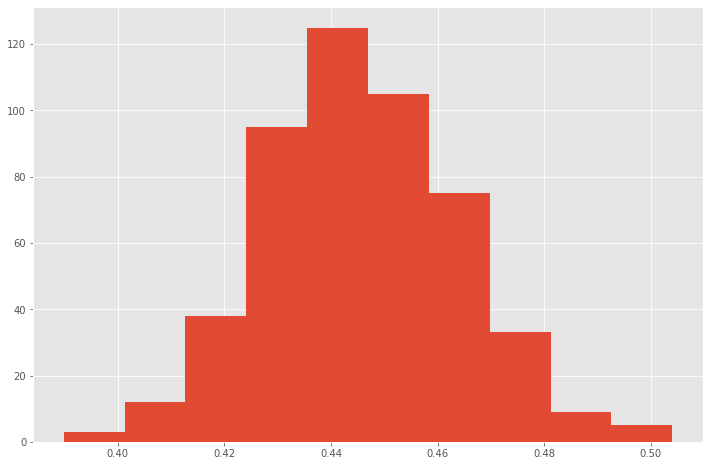

In [119]:
plt.hist(theta);

In [120]:
print("Survey biased sample mean support: ", non_rep_sample.abortion.sum()/len(non_rep_sample.abortion))
print("Survey  biased sample support std: ", math.sqrt(non_rep_sample.abortion.mean()*(1-non_rep_sample.abortion.mean())/len(non_rep_sample.abortion)))
print("Size of the Survey biased sample:  ", len(non_rep_sample.abortion))
print("")
print("MRP mean support estimate from the biased sample: ", theta_non_rep.mean())
print("MRP std: ", theta_non_rep.std())
print("Population size: ", post["n"].sum())
print("")
print("Non census MRP mean support estimate from the biased sample: ", theta.mean())
print("Non census MRP std: ", theta.std())
print("Population size: ", post["n"].sum())
print("")
print("Survey mean support: ", y.numpy().sum()/len(y.numpy()))
print("Survey support std: ", math.sqrt(y.numpy().mean()*(1-y.numpy().mean())/len(y.numpy())))
print("Size of the Survey:  ", len(y.numpy()))
print("")

Survey biased sample mean support:  0.3724
Survey  biased sample support std:  0.006836932645565554
Size of the Survey biased sample:   5000

MRP mean support estimate from the biased sample:  0.39484843485505405
MRP std:  0.01848572562948352
Population size:  228443347

Non census MRP mean support estimate from the biased sample:  0.4459480129494711
Non census MRP std:  0.01815355725550841
Population size:  228443347

Survey mean support:  0.4341581675305133
Survey support std:  0.002026677347449802
Size of the Survey:   59810



We see that when including the non-census variable, the MRP is able to correct for the bias in the survey and the prediction for the population is much closer to the whole 60 000 survey (which as we showed earlier should be a good estimate of the population opinion as this survey is well balanced).